In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import h5py, csv

2024-04-02 21:11:23.681274: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-02 21:11:24.051285: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 21:11:26.150669: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Model Definition
# Modality Specific Module
class ModalitySpecificModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)  
    # video MSM Layers
    self.bigru_video = keras.layers.Bidirectional(keras.layers.GRU(512))
    self.msl_1_video = keras.layers.Dense(256, activation='relu')
    self.msl_2_video = keras.layers.Dense(128, activation='relu')

  def __call__(self, video_input):
    # video MSM
    bigru_video_output = self.bigru_video(video_input)
    msl_l1_video = self.msl_1_video(bigru_video_output)
    video_msm_output = self.msl_2_video(msl_l1_video)
    return video_msm_output

# Sentiment Classification Module
class SentimentClassificationModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.layer_1 = keras.layers.Dense(128, activation='relu')
    self.layer_2 = keras.layers.Dense(64, activation='relu')
    self.layer_3 = keras.layers.Dense(32, activation='relu')
    self.layer_4 = keras.layers.Dense(16, activation='relu')
    num_classes = 5
    self.classification_layer = keras.layers.Dense(num_classes, activation='softmax')

  def __call__(self, video_msm_output):
    output_l1 = self.layer_1(video_msm_output)
    output_l2 = self.layer_2(output_l1)
    output_l3 = self.layer_3(output_l2)
    output_l4 = self.layer_4(output_l3)
    sentiment = self.classification_layer(output_l4)
    return sentiment

# Sentiment Analysis Model
class SA_Model(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.video_input = keras.Input(shape=(5226, 512))

    # Major Modules of DFMR
    self.msm = ModalitySpecificModule()
    self.scm = SentimentClassificationModule()

  def __call__(self):
    # major module structure overview
    video_msm_output= self.msm(self.video_input)
    output = self.scm(video_msm_output)    
    # model definition
    model = keras.Model(inputs=[self.video_input], outputs=output)
    return model


sa_model = SA_Model()
model = sa_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5226, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1024)           │     3,151,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,474,629 (13.25 MB)

 Trainable params: 3,474,629 (13.25 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
model.compile(
  optimizer='adam',
  loss=keras.losses.MeanAbsoluteError(),
  metrics=[
    keras.metrics.Accuracy()
  ]
)

In [4]:
video_embeddings = {}

with h5py.File('../../datasets/Dravidian Dataset/malayalam_data/embeddings/video_embeddings.h5', 'r') as f:
  v_ids = list(f.keys())
  v_max_shape = f[v_ids[0]].shape
  for i in v_ids:
    video_embeddings[i] = f[i][:]
    shape = f[i].shape
    if v_max_shape < shape:
      v_max_shape = shape

  for key,value in video_embeddings.items():
    padded_value = np.pad(value, ((0, v_max_shape[0] - value.shape[0]), (0, v_max_shape[1] - value.shape[1])), mode='constant')
    video_embeddings[key] = padded_value
    # print(video_embeddings[key].shape)

In [5]:
video_embeddings_list = []
for k in v_ids:
  video_embeddings_list.append(video_embeddings[k])
video_embeddings_array = np.array(video_embeddings_list)
v_eager_tensor = tf.convert_to_tensor(video_embeddings_array)
print(v_eager_tensor.shape)

(69, 5226, 512)


In [6]:
def convertLabels(label):
  rep = {
    -2 : [1., 0., 0., 0., 0.],
    -1 : [0., 1., 0., 0., 0.],
    0 : [0., 0., 1., 0., 0.],
    1 : [0., 0., 0., 1., 0.],
    2 : [0., 0., 0., 0., 1.]
  }
  return tf.convert_to_tensor(rep[label])

video_input = v_eager_tensor

labels_dict = {}
labels_list = []
labels_path = '../../datasets/Dravidian Dataset/malayalam_data/labels/labels.csv'
with open(labels_path, newline='') as csvfile:
  reader = csv.DictReader(csvfile)
  # removed MAL_MSA_18 since it has no video file
  for row,k in zip(reader, v_ids):
    labels_dict[k] = convertLabels(int(row['label']))
    labels_list.append(labels_dict[k])
labels_array = np.array(labels_list)
labels_eager_tensor = tf.convert_to_tensor(labels_array)
print(labels_eager_tensor.shape)

label_input = labels_eager_tensor

(69, 5)


In [7]:
video_train = video_input[0:55]
label_train = label_input[0:55]

video_validation = video_input[49:55]
label_validation = label_input[49:55]

video_test = video_input[59:62]
label_test = label_input[59:62]

train_dataset = [video_train]
validation_data = ([video_validation], label_validation)
test_dataset = [video_test]

In [8]:
epochs = 100
history = model.fit(train_dataset, label_train, validation_data=validation_data, epochs=epochs)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 90s 39s/step - accuracy: 0.0000e+00 - loss: 0.3195 - val_accuracy: 0.0000e+00 - val_loss: 0.3140
Epoch 2/100


2024-04-02 21:13:03.427303: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 75s 37s/step - accuracy: 0.0000e+00 - loss: 0.3055 - val_accuracy: 0.0000e+00 - val_loss: 0.3088
Epoch 3/100


2024-04-02 21:14:18.838838: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 65s 27s/step - accuracy: 0.0000e+00 - loss: 0.2801 - val_accuracy: 0.0000e+00 - val_loss: 0.3003
Epoch 4/100


2024-04-02 21:15:23.938205: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 57s 28s/step - accuracy: 0.0000e+00 - loss: 0.2407 - val_accuracy: 0.0000e+00 - val_loss: 0.2902
Epoch 5/100


2024-04-02 21:16:21.004098: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 57s 28s/step - accuracy: 0.0000e+00 - loss: 0.2105 - val_accuracy: 0.0000e+00 - val_loss: 0.2743
Epoch 6/100


2024-04-02 21:17:17.902518: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 56s 28s/step - accuracy: 0.0000e+00 - loss: 0.1796 - val_accuracy: 0.0000e+00 - val_loss: 0.2532
Epoch 7/100


2024-04-02 21:18:13.742565: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 56s 28s/step - accuracy: 0.0000e+00 - loss: 0.1644 - val_accuracy: 0.0000e+00 - val_loss: 0.2271
Epoch 8/100


2024-04-02 21:19:10.227665: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 55s 27s/step - accuracy: 0.0135 - loss: 0.1559 - val_accuracy: 0.0000e+00 - val_loss: 0.2030
Epoch 9/100


2024-04-02 21:20:32.127208: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 78s 26s/step - accuracy: 0.0139 - loss: 0.1379 - val_accuracy: 0.0000e+00 - val_loss: 0.1765
Epoch 10/100


2024-04-02 21:21:23.477349: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 56s 27s/step - accuracy: 0.0045 - loss: 0.1164 - val_accuracy: 0.0000e+00 - val_loss: 0.1542
Epoch 11/100


2024-04-02 21:22:19.049683: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 54s 27s/step - accuracy: 0.0000e+00 - loss: 0.1026 - val_accuracy: 0.0000e+00 - val_loss: 0.1375
Epoch 12/100


2024-04-02 21:23:13.420163: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 56s 27s/step - accuracy: 0.0000e+00 - loss: 0.0765 - val_accuracy: 0.0000e+00 - val_loss: 0.1147
Epoch 13/100


2024-04-02 21:24:09.298218: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 55s 27s/step - accuracy: 0.0000e+00 - loss: 0.0583 - val_accuracy: 0.0000e+00 - val_loss: 0.0873
Epoch 14/100


2024-04-02 21:25:31.199308: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 78s 26s/step - accuracy: 0.0024 - loss: 0.0432 - val_accuracy: 0.0000e+00 - val_loss: 0.0632
Epoch 15/100


2024-04-02 21:26:22.264830: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 60s 31s/step - accuracy: 0.0069 - loss: 0.0242 - val_accuracy: 0.0000e+00 - val_loss: 0.0203
Epoch 16/100


2024-04-02 21:27:22.638642: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 66s 32s/step - accuracy: 0.0024 - loss: 0.0129 - val_accuracy: 0.0000e+00 - val_loss: 0.0114
Epoch 17/100


2024-04-02 21:28:28.682455: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 80s 42s/step - accuracy: 0.0357 - loss: 0.0125 - val_accuracy: 0.0000e+00 - val_loss: 0.0070
Epoch 18/100


2024-04-02 21:29:48.731088: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 83s 41s/step - accuracy: 0.0503 - loss: 0.0052 - val_accuracy: 0.0000e+00 - val_loss: 0.0048
Epoch 19/100


2024-04-02 21:31:11.429214: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 80s 39s/step - accuracy: 0.0229 - loss: 0.0043 - val_accuracy: 0.0000e+00 - val_loss: 0.0046
Epoch 20/100


2024-04-02 21:32:31.014979: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 85s 40s/step - accuracy: 0.0187 - loss: 0.0043 - val_accuracy: 0.0000e+00 - val_loss: 0.0089
Epoch 21/100


2024-04-02 21:33:55.665378: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 81s 40s/step - accuracy: 0.0305 - loss: 0.0038 - val_accuracy: 0.0333 - val_loss: 0.0017
Epoch 22/100


2024-04-02 21:35:16.419652: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 39s/step - accuracy: 0.0506 - loss: 0.0014 - val_accuracy: 0.0667 - val_loss: 0.0012
Epoch 23/100


2024-04-02 21:36:33.053611: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 87s 44s/step - accuracy: 0.0596 - loss: 4.5288e-04 - val_accuracy: 0.0333 - val_loss: 0.0024
Epoch 24/100


2024-04-02 21:37:59.904232: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 75s 41s/step - accuracy: 0.0489 - loss: 4.7640e-04 - val_accuracy: 0.0333 - val_loss: 0.0041
Epoch 25/100


2024-04-02 21:39:14.516608: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 85s 45s/step - accuracy: 0.0593 - loss: 0.0018 - val_accuracy: 0.0333 - val_loss: 0.0010
Epoch 26/100


2024-04-02 21:41:36.419285: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 143s 40s/step - accuracy: 0.0509 - loss: 2.6485e-04 - val_accuracy: 0.0667 - val_loss: 1.7818e-04
Epoch 27/100


2024-04-02 21:43:58.331339: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 136s 35s/step - accuracy: 0.0620 - loss: 2.4201e-04 - val_accuracy: 0.0667 - val_loss: 1.2659e-04
Epoch 28/100


2024-04-02 21:45:17.962404: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 59s 27s/step - accuracy: 0.0645 - loss: 3.4776e-04 - val_accuracy: 0.0667 - val_loss: 1.3445e-04
Epoch 29/100


2024-04-02 21:46:17.395583: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 59s 30s/step - accuracy: 0.0707 - loss: 3.2866e-04 - val_accuracy: 0.0667 - val_loss: 1.6383e-04
Epoch 30/100


2024-04-02 21:47:16.268711: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 58s 28s/step - accuracy: 0.0561 - loss: 2.6871e-04 - val_accuracy: 0.0667 - val_loss: 2.0790e-04
Epoch 31/100


2024-04-02 21:48:13.995382: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 58s 29s/step - accuracy: 0.0707 - loss: 1.0389e-04 - val_accuracy: 0.0667 - val_loss: 2.3429e-04
Epoch 32/100


2024-04-02 21:49:11.716460: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 60s 29s/step - accuracy: 0.0686 - loss: 7.8913e-05 - val_accuracy: 0.0667 - val_loss: 2.4059e-04
Epoch 33/100


2024-04-02 21:50:11.552161: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 64s 33s/step - accuracy: 0.0645 - loss: 5.3454e-05 - val_accuracy: 0.0667 - val_loss: 2.0171e-04
Epoch 34/100


2024-04-02 21:51:15.761258: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 69s 38s/step - accuracy: 0.0603 - loss: 4.4541e-05 - val_accuracy: 0.0667 - val_loss: 1.4146e-04
Epoch 35/100


2024-04-02 21:52:24.316756: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 86s 45s/step - accuracy: 0.0603 - loss: 3.3358e-05 - val_accuracy: 0.0667 - val_loss: 9.8880e-05
Epoch 36/100


2024-04-02 21:53:49.912216: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 85s 45s/step - accuracy: 0.0690 - loss: 2.1495e-05 - val_accuracy: 0.0667 - val_loss: 7.1482e-05
Epoch 37/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 85s 42s/step - accuracy: 0.0669 - loss: 1.7783e-05 - val_accuracy: 0.0667 - val_loss: 5.2963e-05
Epoch 38/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 82s 39s/step - accuracy: 0.0648 - loss: 1.5695e-05 - val_accuracy: 0.0667 - val_loss: 4.0127e-05
Epoch 39/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 38s/step - accuracy: 0.0648 - loss: 1.4046e-05 - val_accuracy: 0.0667 - val_loss: 3.1806e-05
Epoch 40/100


2024-04-02 21:59:24.289765: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 83s 39s/step - accuracy: 0.0690 - loss: 1.3175e-05 - val_accuracy: 0.0667 - val_loss: 2.5922e-05
Epoch 41/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 79s 38s/step - accuracy: 0.0711 - loss: 1.0960e-05 - val_accuracy: 0.0667 - val_loss: 2.1902e-05
Epoch 42/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 39s/step - accuracy: 0.0627 - loss: 1.0449e-05 - val_accuracy: 0.0667 - val_loss: 1.8943e-05
Epoch 43/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 39s/step - accuracy: 0.0627 - loss: 9.5665e-06 - val_accuracy: 0.0667 - val_loss: 1.6777e-05
Epoch 44/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 75s 38s/step - accuracy: 0.0669 - loss: 7.8579e-06 - val_accuracy: 0.0667 - val_loss: 1.5124e-05
Epoch 45/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 78s 40s/step - accuracy: 0.0711 - loss: 7.7767e-06 - val_accuracy: 0.0667 - val_loss: 1.3797e-05
Epoch 46/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 59s 26s/step - accuracy: 0.0690 - loss: 7.5831e-06 - val_accuracy: 0.0667 - val_loss: 1.2755e-05
Epoch 47/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 54s 28s/step - accuracy: 0.069

2024-04-02 22:09:01.343961: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 58s 29s/step - accuracy: 0.0714 - loss: 6.3678e-06 - val_accuracy: 0.0667 - val_loss: 1.1191e-05
Epoch 49/100


2024-04-02 22:09:59.589785: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 63s 34s/step - accuracy: 0.0735 - loss: 6.4623e-06 - val_accuracy: 0.0667 - val_loss: 1.0585e-05
Epoch 50/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 75s 41s/step - accuracy: 0.0735 - loss: 5.9036e-06 - val_accuracy: 0.0667 - val_loss: 1.0083e-05
Epoch 51/100


2024-04-02 22:12:18.563757: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 84s 41s/step - accuracy: 0.0777 - loss: 5.8202e-06 - val_accuracy: 0.0667 - val_loss: 9.6434e-06
Epoch 52/100


2024-04-02 22:13:42.174100: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 85s 42s/step - accuracy: 0.0780 - loss: 5.7893e-06 - val_accuracy: 0.0667 - val_loss: 9.2679e-06
Epoch 53/100


2024-04-02 22:15:06.790807: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 84s 41s/step - accuracy: 0.0759 - loss: 5.1730e-06 - val_accuracy: 0.0667 - val_loss: 8.9504e-06
Epoch 54/100


2024-04-02 22:17:28.690598: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 133s 35s/step - accuracy: 0.0801 - loss: 5.4514e-06 - val_accuracy: 0.0667 - val_loss: 8.6623e-06
Epoch 55/100


2024-04-02 22:18:43.693400: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 76s 38s/step - accuracy: 0.0801 - loss: 5.1606e-06 - val_accuracy: 0.0667 - val_loss: 8.3956e-06
Epoch 56/100


2024-04-02 22:19:59.241172: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 73s 38s/step - accuracy: 0.0780 - loss: 4.7720e-06 - val_accuracy: 0.0667 - val_loss: 8.1680e-06
Epoch 57/100


2024-04-02 22:21:12.603888: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 81s 41s/step - accuracy: 0.0759 - loss: 4.9495e-06 - val_accuracy: 0.0667 - val_loss: 7.9551e-06
Epoch 58/100


2024-04-02 22:22:33.941641: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 79s 40s/step - accuracy: 0.0780 - loss: 5.1269e-06 - val_accuracy: 0.0667 - val_loss: 7.7625e-06
Epoch 59/100


2024-04-02 22:23:52.891883: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 79s 39s/step - accuracy: 0.0842 - loss: 4.6114e-06 - val_accuracy: 0.0667 - val_loss: 7.5738e-06
Epoch 60/100


2024-04-02 22:25:11.929904: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 55s 29s/step - accuracy: 0.0801 - loss: 4.7309e-06 - val_accuracy: 0.0667 - val_loss: 7.4076e-06
Epoch 61/100


2024-04-02 22:26:07.041791: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 55s 27s/step - accuracy: 0.0780 - loss: 4.5614e-06 - val_accuracy: 0.0667 - val_loss: 7.2368e-06
Epoch 62/100


2024-04-02 22:27:02.137000: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 55s 27s/step - accuracy: 0.0697 - loss: 4.8003e-06 - val_accuracy: 0.0667 - val_loss: 7.0855e-06
Epoch 63/100


2024-04-02 22:27:57.190749: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 342491776 bytes after encountering the first element of size 342491776 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 55s 29s/step - accuracy: 0.0780 - loss: 4.2924e-06 - val_accuracy: 0.0667 - val_loss: 6.9416e-06
Epoch 64/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 58s 28s/step - accuracy: 0.0738 - loss: 4.5288e-06 - val_accuracy: 0.0667 - val_loss: 6.8053e-06
Epoch 65/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 54s 27s/step - accuracy: 0.0759 - loss: 4.1326e-06 - val_accuracy: 0.0667 - val_loss: 6.6733e-06
Epoch 66/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 54s 27s/step - accuracy: 0.0783 - loss: 3.9993e-06 - val_accuracy: 0.0667 - val_loss: 6.5651e-06
Epoch 67/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 54s 27s/step - accuracy: 0.0804 - loss: 3.9408e-06 - val_accuracy: 0.0667 - val_loss: 6.4528e-06
Epoch 68/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 54s 27s/step - accuracy: 0.0825 - loss: 4.1128e-06 - val_accuracy: 0.0667 - val_loss: 6.3437e-06
Epoch 69/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 54s 26s/step - accuracy: 0.0804 - loss: 3.9714e-06 - val_accuracy: 0.0667 - val_loss: 6.2462e-06
Epoch 70/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 54s 27s/step - accuracy: 0.076

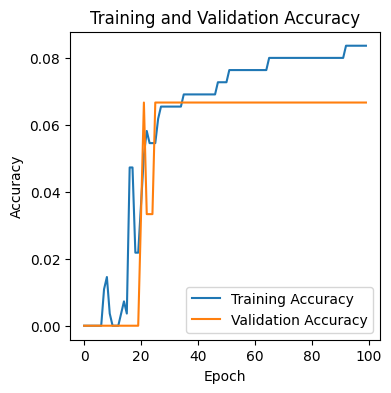

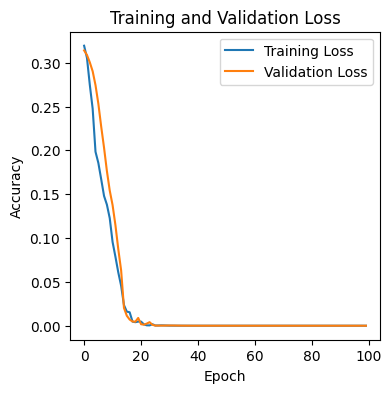

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(4, 4))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure(figsize=(4, 4))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
print("Evaluate on test data")
results = model.evaluate(test_dataset, label_test)
print("test loss, test acc:", results)

Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 0.3489
test loss, test acc: [0.34885790944099426, 0.0]
